In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
import pandas as pd
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

In [4]:
import acquire

# read the data into df
df = acquire.new_mall_customers()

In [5]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
# create dummy vars of 'gender' column, drop the first dummy var and keep remaining. 
# In testing, I see there is one dummy var returned, 'Male', so I 
# create a new column in our df, 'is_male', to hold the values for the new dummy var. 

df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
df.drop(columns=['gender'], inplace=True)
df.head()

,customer_id,age,annual_income,spending_score,is_male
0,1,19,15,39,1
1,2,21,15,81,1
2,3,20,16,6,0
3,4,23,16,77,0
4,5,31,17,40,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     200 non-null    int64
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
 4   is_male         200 non-null    uint8
dtypes: int64(4), uint8(1)
memory usage: 6.6 KB


In [8]:
df.describe()

,customer_id,age,annual_income,spending_score,is_male
count,200.00,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20,0.44
std,57.88,13.97,26.26,25.82,0.50
min,1.00,18.00,15.00,1.00,0.00
25%,50.75,28.75,41.50,34.75,0.00
50%,100.50,36.00,61.50,50.00,0.00
75%,150.25,49.00,78.00,73.00,1.00
max,200.00,70.00,137.00,99.00,1.00


In [9]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  560
validate observations:  240
test observations:  200


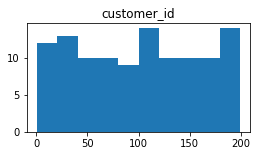

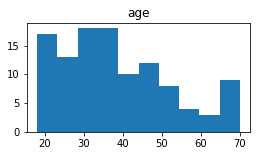

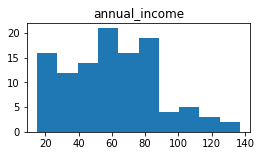

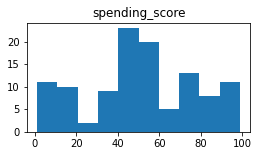

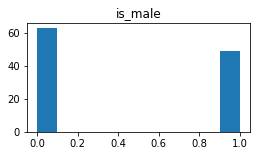

In [10]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

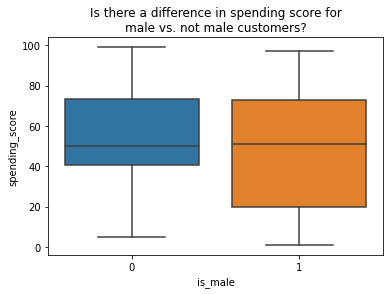

In [11]:
sns.boxplot(train.is_male, train.spending_score)
plt.title("Is there a difference in spending score for\nmale vs. not male customers?")
plt.show()

In [12]:
# test the equal variance 
# H0 is that the variances are equal
# Levene test
# our two groups are 1) where train.is_male==0 and 
# 2) where train.is_male == 1

stats.levene(train[train.is_male==0].spending_score, 
             train[train.is_male==1].spending_score)

LeveneResult(statistic=1.52123656007133, pvalue=0.22006154667448222)

In [13]:
stats.ttest_ind(train[train.is_male==0].spending_score, 
                train[train.is_male==1].spending_score, 
                equal_var=True
               )

Ttest_indResult(statistic=0.7973640087804729, pvalue=0.4269574825618323)

Is there a relationship
between annual income and spending score?


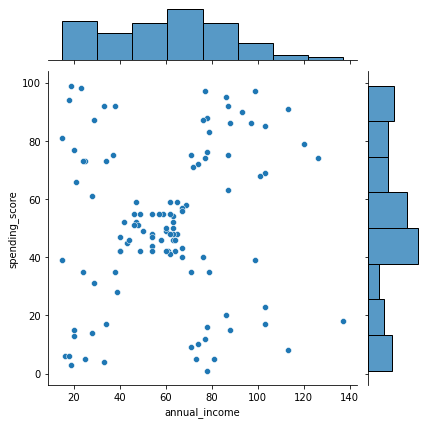

In [14]:
print("Is there a relationship\nbetween annual income and spending score?")
sns.jointplot(x="annual_income", y="spending_score", data=train)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

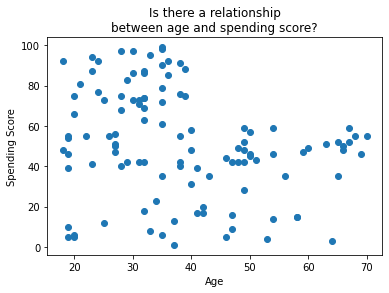

In [15]:
# plot age by spending_score
plt.scatter(train.age, train.spending_score)
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.title("Is there a relationship\nbetween age and spending score?")
plt.show()

In [16]:
# create age bins for < 40 and >= 40 
train['age_bin'] = pd.cut(train.age, [0,40, 80])

train.head()

,customer_id,age,annual_income,spending_score,is_male,age_bin
130,131,47,71,9,1,"(40, 80]"
62,63,67,47,52,0,"(40, 80]"
13,14,24,20,77,0,"(0, 40]"
173,174,36,87,92,1,"(0, 40]"
144,145,25,77,12,1,"(0, 40]"


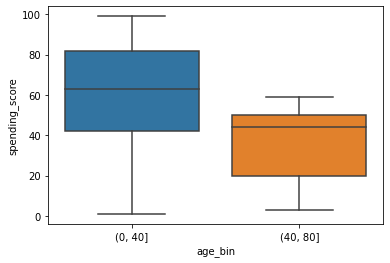

In [17]:
# box plot of the two groups and spending score
sns.boxplot(train.age_bin, train.spending_score)
plt.show()

In [18]:
# test the assumption of equal variance

stats.levene(train[train.age <= 40].spending_score, 
             train[train.age > 40].spending_score
            )

LeveneResult(statistic=11.809551017293076, pvalue=0.0008325687159373646)

In [19]:
# variances are unequal
# t-test, 2-sample (independent), 2-tail. 

stats.ttest_ind(train[train.age <= 40].spending_score, 
                train[train.age > 40].spending_score,
                equal_var=False
               )

Ttest_indResult(statistic=5.011777953183408, pvalue=2.087595446622472e-06)

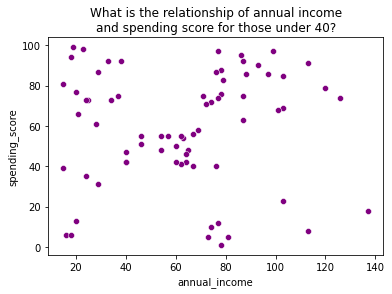

In [20]:
sns.scatterplot(x='annual_income', y='spending_score', 
                data=train[train.age <= 40], 
                color='purple'
               )

plt.title("What is the relationship of annual income\nand spending score for those under 40?")
plt.show()

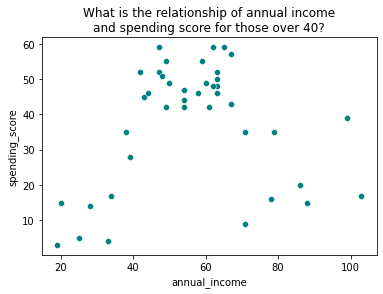

In [21]:
sns.scatterplot(x='annual_income', y='spending_score',
                data=train[train.age > 40],
                color='teal'
               )
plt.title("What is the relationship of annual income\nand spending score for those over 40?")
plt.show()

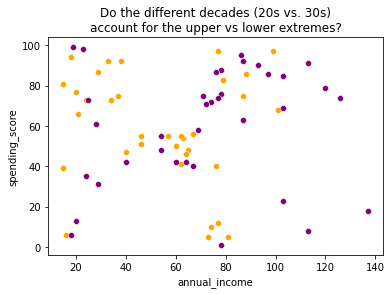

In [22]:
sns.scatterplot(x='annual_income', y='spending_score',
                data=train[train.age<=30], color='orange')

sns.scatterplot(x='annual_income', y='spending_score',
                data=train[(train.age>30) & (train.age<=40)], 
                color='purple')

plt.title("Do the different decades (20s vs. 30s)\naccount for the upper vs lower extremes?")
plt.show()

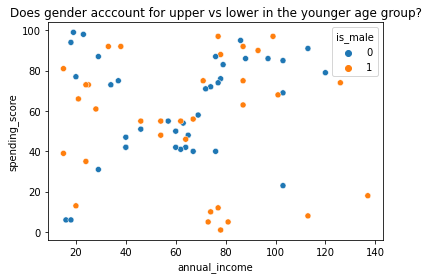

In [23]:
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.age <= 40], hue='is_male')

plt.title("Does gender acccount for upper vs lower in the younger age group?")
plt.show()

In [24]:
# bin income into 3 bins

train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

In [25]:
train.head()

,customer_id,age,annual_income,spending_score,is_male,age_bin,income_bin
130,131,47,71,9,1,"(40, 80]","(70, 140]"
62,63,67,47,52,0,"(40, 80]","(40, 70]"
13,14,24,20,77,0,"(0, 40]","(0, 40]"
173,174,36,87,92,1,"(0, 40]","(70, 140]"
144,145,25,77,12,1,"(0, 40]","(70, 140]"


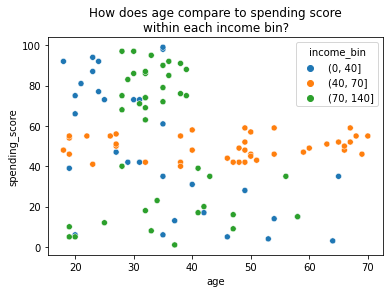

In [26]:
sns.scatterplot(x='age', y='spending_score',
               data=train, hue='income_bin')
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()

Interaction of variables along with younger vs older
(cutoff=40)


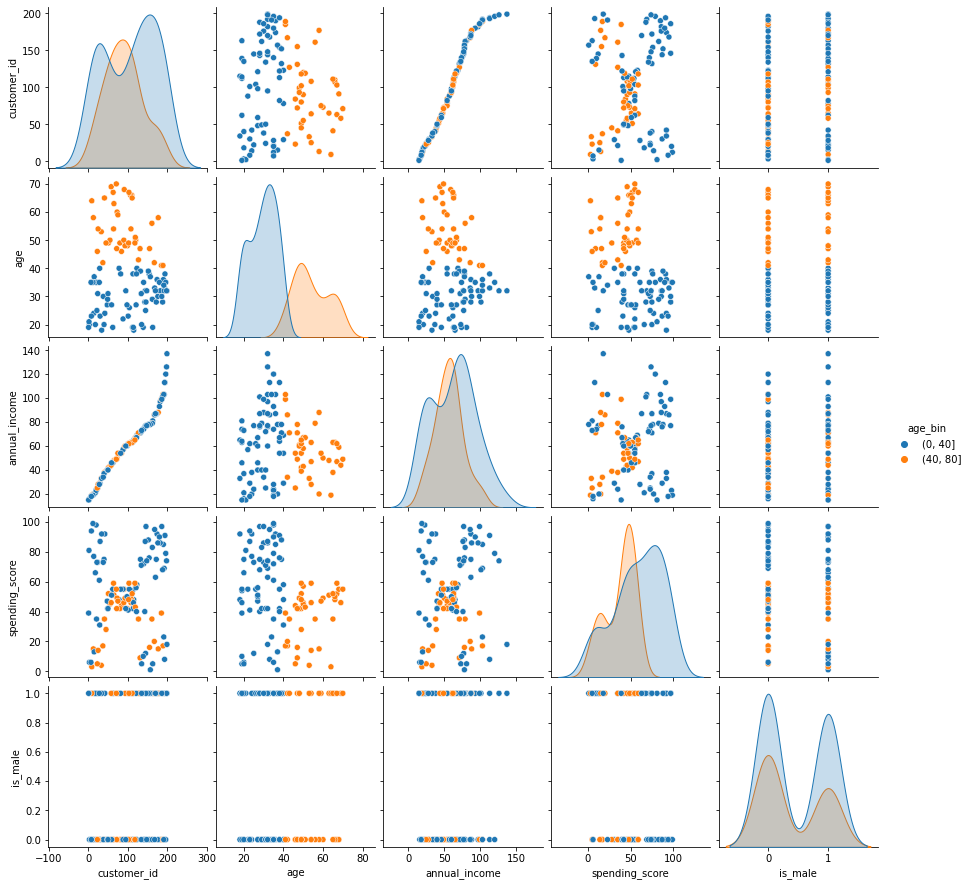

In [27]:
print("Interaction of variables along with younger vs older\n(cutoff=40)")
sns.pairplot(train, hue='age_bin')
plt.show()

Interaction of variables along with income bins


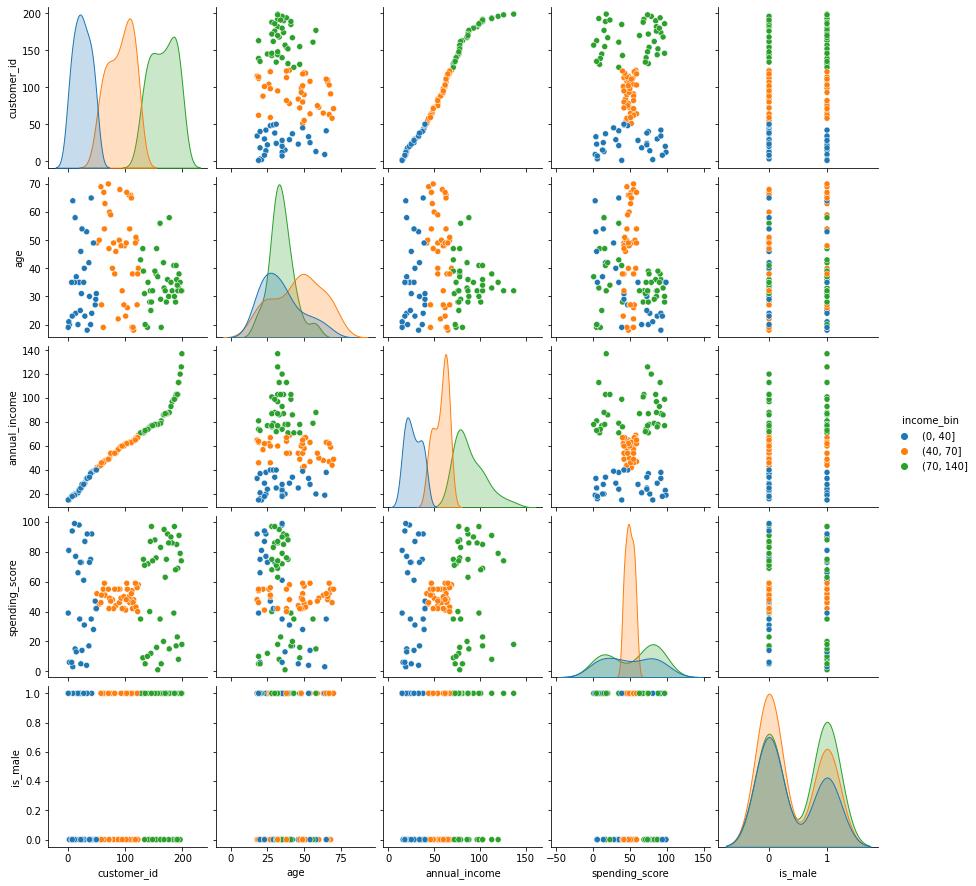

In [28]:
print("Interaction of variables along with income bins")
sns.pairplot(train, hue='income_bin')
plt.show()

Interaction of variables along with gender


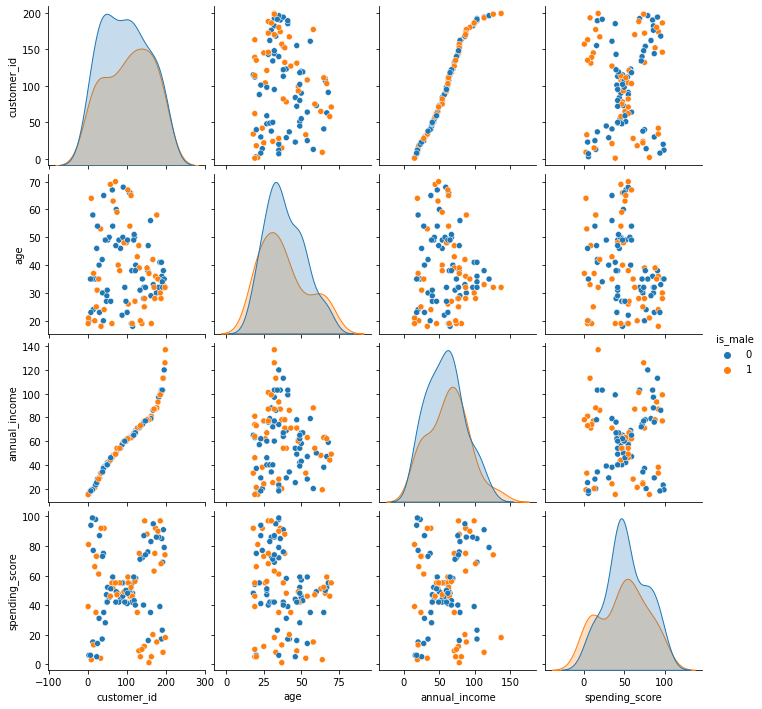

In [29]:
print("Interaction of variables along with gender")
sns.pairplot(train, hue='is_male')
plt.show()

<AxesSubplot:xlabel='is_male'>

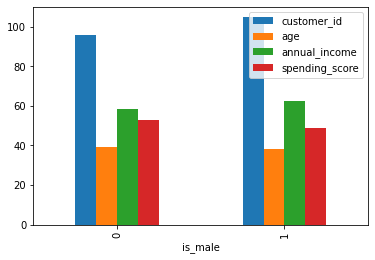

In [30]:
train.groupby('is_male').mean().plot.bar()